# ⚾**Predicting The Outcome of MLB Plate Appearances**⚾
## Jaypal Bhatia, Noor Gill, Casey McGonigle & Mickey Piekarski
### W207 - Applied Machine Learning - Final Project
#### Dec 7, 2021

---
## **Table of Contents**


1. Imports
2. Clustering
3. X-Matrix Creation
4. Understand League Averages
5. Present 1st Model in Detail
6. Compare to Test Set?
7. Other Models
8. Dugout
9. Potential Next Steps







## **Import Packages & Data** 

#### Import Packages

In [439]:
import pandas as pd
import numpy as np

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import altair as alt

from IPython.display import display
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from collections import Counter



In [440]:
#!pip install pybaseball
from pybaseball import statcast
import pybaseball
pybaseball.cache.enable()

from pybaseball import playerid_reverse_lookup

In [441]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Pull in 2021 data

In [442]:
full_2021 = statcast(start_dt = "2021-04-01", end_dt = '2021-10-03')


This is a large query, it may take a moment to complete


100%|██████████| 186/186 [00:11<00:00, 15.86it/s]


In [443]:
full_2021.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
2969,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,...,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.000,-0.073
2999,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,None,foul,<NA>,<NA>,<NA>,<NA>,4,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,<NA>,None,1,1,2021,-0.77,0.48,-0.71,2.62,<NA>,<NA>,<NA>,2,9,Top,NaN,NaN,<NA>,...,108,75.3,75,81.2,2254,6.4,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.15,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,61,3,Slider,5,0,0,5,0,5,0,5,Infield shift,Strategic,315,0.000,-0.027
3222,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,None,foul,<NA>,<NA>,<NA>,<NA>,5,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,<NA>,None,1,0,2021,-0.65,-0.51,-0.04,2.46,<NA>,<NA>,<NA>,2,9,Top,NaN,NaN,<NA>,...,157,83.5,65,75.2,1940,6.2,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.34,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,61,2,Curveball,5,0,0,5,0,5,0,5,Infield shift,Standard,328,0.000,-0.020
3441,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,None,ball,<NA>,<NA>,<NA>,<NA>,12,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,<NA>,None,0,0,2021,-0.69,-0.69,2.10,3.89,<NA>,<NA>,<NA>,2,9,Top,NaN,NaN,<NA>,...,<NA>,NaN,<NA>,74.5,2017,5.9,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.61,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330,0.000,0.016
3593,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,4,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,<NA>,<NA>,<NA>,1,9,Top,144.83,145.72,<NA>,...,9,93.3,-18,90.9,2281,6.3,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.15,0.100,0.090,0.0,1,0,0,2,60,2,4-Seam Fastball,5,0,0,5,0,5,0,5,Standard,Standard,143,0.002,-0.189


In [444]:
full_2021.shape

(709851, 92)

In [445]:
## Saving this DF 
full_2021.to_csv("full_2021.csv")

#### Filter so we only get the columns we want

In [446]:
## Inspect all the Columns of full_2021
full_2021.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [447]:
## Create table that only has the columns we want
my_cols = ["game_date", "home_team", "away_team", 'inning_topbot', "player_name", "batter", "pitcher",  
        "stand", "p_throws","inning", "outs_when_up", "on_1b", "on_2b", "on_3b", 
         "bat_score", "fld_score", "if_fielding_alignment", "of_fielding_alignment",
         "events"]

pitches_2021 = full_2021[my_cols]
pitches_2021.head(100)

,game_date,home_team,away_team,inning_topbot,player_name,batter,pitcher,stand,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,events
2969,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,<NA>,<NA>,<NA>,0,5,Infield shift,Strategic,field_out
2999,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,<NA>,<NA>,<NA>,0,5,Infield shift,Strategic,None
3222,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,<NA>,<NA>,<NA>,0,5,Infield shift,Standard,None
3441,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,<NA>,<NA>,<NA>,0,5,Standard,Standard,None
3593,2021-10-03,ATL,NYM,Top,"Smith, Will",607043,519293,L,L,9,1,<NA>,<NA>,<NA>,0,5,Standard,Standard,field_out
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,2021-10-03,ATL,NYM,Top,"Matzek, Tyler",542340,554431,R,L,5,0,<NA>,<NA>,<NA>,0,5,Standard,Standard,None
382,2021-10-03,ATL,NYM,Bot,"Williams, Trevor",518692,592866,L,R,4,2,<NA>,621020,518595,5,0,Strategic,Standard,field_out
405,2021-10-03,ATL,NYM,Bot,"Williams, Trevor",518692,592866,L,R,4,2,<NA>,621020,518595,5,0,Strategic,Standard,None
409,2021-10-03,ATL,NYM,Bot,"Williams, Trevor",518692,592866,L,R,4,2,<NA>,621020,518595,5,0,Strategic,Standard,None


#### Filter out all rows with event == NaN 
b/c we only want the outcomes of Plate Appearances

In [448]:
print("percent na:", sum(pitches_2021["events"].isna())/len(pitches_2021))
print("num event: ", len(pitches_2021) - sum(pitches_2021["events"].isna()))

## Filter out any rows that have events == NaN
events_2021 = pitches_2021[pitches_2021.events.notnull()]
## Rename the "Stand" column to "h_hits"
events_2021 = events_2021.rename(columns = {"stand": "h_hits"})
events_2021

percent na: 0.7445266682726375
num event:  181348


,game_date,home_team,away_team,inning_topbot,player_name,batter,pitcher,h_hits,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,events
2969,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,<NA>,<NA>,<NA>,0,5,Infield shift,Strategic,field_out
3593,2021-10-03,ATL,NYM,Top,"Smith, Will",607043,519293,L,L,9,1,<NA>,<NA>,<NA>,0,5,Standard,Standard,field_out
3891,2021-10-03,ATL,NYM,Top,"Smith, Will",641645,519293,L,L,9,0,<NA>,<NA>,<NA>,0,5,Standard,Standard,strikeout
2400,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",594807,607229,R,R,8,2,<NA>,<NA>,<NA>,5,0,Infield shift,Standard,field_out
2727,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",663586,607229,R,R,8,1,<NA>,<NA>,<NA>,5,0,Infield shift,Standard,strikeout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2021-04-01,COL,LAD,Top,"Márquez, Germán",571970,608566,L,R,1,2,641355,608369,<NA>,0,0,Standard,Standard,field_out
2039,2021-04-01,COL,LAD,Top,"Márquez, Germán",641355,608566,L,R,1,2,<NA>,608369,<NA>,0,0,Standard,Standard,walk
2775,2021-04-01,COL,LAD,Top,"Márquez, Germán",457759,608566,R,R,1,0,608369,605141,<NA>,0,0,Standard,Standard,grounded_into_double_play
3288,2021-04-01,COL,LAD,Top,"Márquez, Germán",608369,608566,L,R,1,0,605141,<NA>,<NA>,0,0,Infield shift,Standard,single


#### Clean & Replace the on_3b, on_2b, and on_1b columns --> One-Hot Encoding

In [449]:
## Replace any NaN values with 0s
events_2021["on_3b"] = events_2021['on_3b'].fillna(0)
events_2021["on_2b"] = events_2021['on_2b'].fillna(0)
events_2021["on_1b"] = events_2021['on_1b'].fillna(0)

In [450]:
## Replace all Non-Zero values with 1s
events_2021["on_3b"][events_2021["on_3b"] != 0] = 1
events_2021["on_2b"][events_2021["on_2b"] != 0] = 1
events_2021["on_1b"][events_2021["on_1b"] != 0] = 1

In [451]:
## Create Column score_diff_offense to keep track of the difference between the runs scored for each team
events_2021["score_diff_offense"] = events_2021["bat_score"] - events_2021["fld_score"]
events_2021.head(40)

,game_date,home_team,away_team,inning_topbot,player_name,batter,pitcher,h_hits,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,events,score_diff_offense
2969,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,0,0,0,0,5,Infield shift,Strategic,field_out,-5
3593,2021-10-03,ATL,NYM,Top,"Smith, Will",607043,519293,L,L,9,1,0,0,0,0,5,Standard,Standard,field_out,-5
3891,2021-10-03,ATL,NYM,Top,"Smith, Will",641645,519293,L,L,9,0,0,0,0,0,5,Standard,Standard,strikeout,-5
2400,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",594807,607229,R,R,8,2,0,0,0,5,0,Infield shift,Standard,field_out,5
2727,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",663586,607229,R,R,8,1,0,0,0,5,0,Infield shift,Standard,strikeout,5
3675,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",645277,607229,L,R,8,0,0,0,0,5,0,Infield shift,Standard,field_out,5
1946,2021-10-03,ATL,NYM,Top,"Martin, Chris",664850,455119,L,R,8,2,0,0,0,0,5,Infield shift,Standard,strikeout,-5
2466,2021-10-03,ATL,NYM,Top,"Martin, Chris",606299,455119,R,R,8,1,0,0,0,0,5,Standard,Standard,field_out,-5
2644,2021-10-03,ATL,NYM,Top,"Martin, Chris",542340,455119,L,R,8,0,0,0,0,0,5,Standard,Standard,field_out,-5
2838,2021-10-03,ATL,NYM,Bot,"Hembree, Heath",606115,592390,R,R,7,2,0,0,0,5,0,Infield shift,Standard,field_out,5


In [452]:
events_2021.to_csv("events_2021.csv")
events_2021

,game_date,home_team,away_team,inning_topbot,player_name,batter,pitcher,h_hits,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,events,score_diff_offense
2969,2021-10-03,ATL,NYM,Top,"Smith, Will",596019,519293,R,L,9,2,0,0,0,0,5,Infield shift,Strategic,field_out,-5
3593,2021-10-03,ATL,NYM,Top,"Smith, Will",607043,519293,L,L,9,1,0,0,0,0,5,Standard,Standard,field_out,-5
3891,2021-10-03,ATL,NYM,Top,"Smith, Will",641645,519293,L,L,9,0,0,0,0,0,5,Standard,Standard,strikeout,-5
2400,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",594807,607229,R,R,8,2,0,0,0,5,0,Infield shift,Standard,field_out,5
2727,2021-10-03,ATL,NYM,Bot,"Gsellman, Robert",663586,607229,R,R,8,1,0,0,0,5,0,Infield shift,Standard,strikeout,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2021-04-01,COL,LAD,Top,"Márquez, Germán",571970,608566,L,R,1,2,1,1,0,0,0,Standard,Standard,field_out,0
2039,2021-04-01,COL,LAD,Top,"Márquez, Germán",641355,608566,L,R,1,2,0,1,0,0,0,Standard,Standard,walk,0
2775,2021-04-01,COL,LAD,Top,"Márquez, Germán",457759,608566,R,R,1,0,1,1,0,0,0,Standard,Standard,grounded_into_double_play,0
3288,2021-04-01,COL,LAD,Top,"Márquez, Germán",608369,608566,L,R,1,0,1,0,0,0,0,Infield shift,Standard,single,0


## **Create Clusters** 

### Pitchers Clustering

#### Pull in Season-level stats for pitchers




In [453]:
p = pd.read_csv('/content/drive/MyDrive/Final Project 207/Mickey - EDA/savant_pitchers.csv')
p.head()

,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,3205,554430,"Wheeler, Zack",3205,100.0,0.215,0.106,0.291,0.321,0.257,0.258,0.215,169,785,83.8,7.7,2351,93.8,94.87,441,1663,1542,1.1,7.15,111,152,113,149,294,322,293
1,3196,641816,"Mahle, Tyler",3196,100.0,0.234,0.162,0.303,0.396,0.308,0.298,0.229,158,674,86.5,12.0,2314,90.5,90.89,410,1445,1751,0.4,6.59,113,154,117,148,294,318,291
2,3164,622491,"Castillo, Luis",3164,100.0,0.255,0.148,0.323,0.402,0.318,0.293,0.232,181,711,86.4,3.5,2194,92.6,91.09,447,1559,1605,-1.5,5.55,114,152,117,147,291,319,291
3,3152,621111,"Buehler, Walker",3152,100.0,0.199,0.130,0.250,0.329,0.255,0.272,0.218,149,747,87.0,10.2,2537,91.1,91.26,407,1550,1602,0.2,6.38,113,157,117,151,298,318,295
4,3141,592662,"Ray, Robbie",3141,100.0,0.210,0.190,0.269,0.401,0.287,0.292,0.218,150,714,90.3,17.4,2217,91.9,91.92,527,1632,1509,0.0,6.42,106,154,120,147,298,319,289


#### Take out rows and columns we don't want

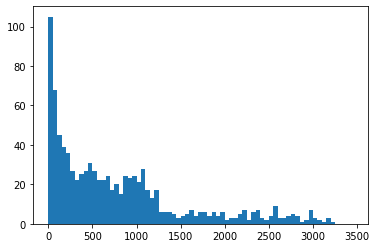

In [454]:
## Look at the distribution of the # of pitches thrown by pitchers throughout the year
plt.hist(p['pitches'],bins = np.arange(0,3500,50));

In [455]:
## remove all players who threw less than 100 pitchers & drop na
p = p[p['pitches']>100]
p = p.dropna()
p.shape

(735, 31)

In [456]:
names = p['player_name']
ids = p['player_id']

In [457]:
## only get columns we want (take out positional location data)
columns = [ 'total_pitches',
       'ba', 'iso', 'babip', 'slg', 'woba', 'xwoba', 'xba', 'hits', 'abs',
       'launch_speed', 'launch_angle', 'spin_rate', 'velocity',
       'effective_speed', 'whiffs', 'swings', 'takes', 'eff_min_vel',
       'release_extension']
p = p[columns]

#### Finally: Clustering!

In [458]:
## Scale Data
scaler = StandardScaler()
p_scaled = pd.DataFrame(scaler.fit_transform(p))
p_scaled.columns = columns
p_scaled.head()

,total_pitches,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,release_extension
0,2.968330,-0.695575,-0.935316,-0.060839,-0.958018,-1.213227,-1.407365,-0.763774,2.637617,3.172103,-1.888299,-0.793920,0.567495,1.692294,1.960547,3.253095,3.288684,2.645558,1.296322,2.067958
1,2.956453,-0.309436,-0.158403,0.168280,-0.251198,-0.301099,-0.540278,-0.392021,2.387460,2.551041,-0.718903,-0.086869,0.381027,0.550811,0.717227,2.941196,2.695807,3.177182,0.653471,0.727678
2,2.914223,0.117348,-0.352631,0.550145,-0.194653,-0.122250,-0.648664,-0.312359,2.910515,2.758062,-0.762214,-1.484529,-0.223734,1.277209,0.779705,3.313462,3.005844,2.805808,-1.091409,-1.761413
3,2.898386,-1.020744,-0.602353,-0.843662,-0.882624,-1.248997,-1.103885,-0.684113,2.182786,2.959487,-0.502348,-0.382844,1.504876,0.758353,0.832812,2.911012,2.981367,2.798177,0.469799,0.225073
4,2.883870,-0.797190,0.230054,-0.480890,-0.204077,-0.676681,-0.670341,-0.684113,2.205527,2.774847,0.926913,0.801057,-0.107822,1.035077,1.038990,4.118362,3.204376,2.561617,0.286128,0.320808


In [459]:
## K-Means Clustering!
kmeans = KMeans(n_clusters = 5)
kmeans.fit(p_scaled)
clusters = kmeans.predict(p_scaled)
p_scaled["Cluster"] = clusters

#### Create Principal Components from the Data & Visualize

---



In [460]:
## Create Principal Component Analysis (2d and 3d!)
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components = 3)

PCs_2d = pd.DataFrame(pca_2d.fit_transform(p_scaled.drop(["Cluster"], axis=1)))
PCs_3d = pd.DataFrame(pca_3d.fit_transform(p_scaled.drop(["Cluster"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [461]:
## Player Names, IDs, Principal Components, and Standardized Season Data to 1 DataFrame
plotX = pd.concat([p_scaled,PCs_2d,PCs_3d], axis=1, join='inner')
plotX['Name'] = names
plotX["player_id"] = ids
plotX.head()

,total_pitches,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,release_extension,Cluster,PC1_2d,PC2_2d,PC1_3d,PC2_3d,PC3_3d,Name,player_id
0,2.968330,-0.695575,-0.935316,-0.060839,-0.958018,-1.213227,-1.407365,-0.763774,2.637617,3.172103,-1.888299,-0.793920,0.567495,1.692294,1.960547,3.253095,3.288684,2.645558,1.296322,2.067958,1,-7.850549,-1.909949,-7.850549,-1.909949,-2.681043,"Wheeler, Zack",554430
1,2.956453,-0.309436,-0.158403,0.168280,-0.251198,-0.301099,-0.540278,-0.392021,2.387460,2.551041,-0.718903,-0.086869,0.381027,0.550811,0.717227,2.941196,2.695807,3.177182,0.653471,0.727678,1,-5.987812,-3.358755,-5.987812,-3.358755,-1.209922,"Mahle, Tyler",641816
2,2.914223,0.117348,-0.352631,0.550145,-0.194653,-0.122250,-0.648664,-0.312359,2.910515,2.758062,-0.762214,-1.484529,-0.223734,1.277209,0.779705,3.313462,3.005844,2.805808,-1.091409,-1.761413,1,-5.987813,-3.964549,-5.987813,-3.964549,-0.019395,"Castillo, Luis",622491
3,2.898386,-1.020744,-0.602353,-0.843662,-0.882624,-1.248997,-1.103885,-0.684113,2.182786,2.959487,-0.502348,-0.382844,1.504876,0.758353,0.832812,2.911012,2.981367,2.798177,0.469799,0.225073,1,-7.081238,-2.009866,-7.081238,-2.009866,-0.809059,"Buehler, Walker",621111
4,2.883870,-0.797190,0.230054,-0.480890,-0.204077,-0.676681,-0.670341,-0.684113,2.205527,2.774847,0.926913,0.801057,-0.107822,1.035077,1.038990,4.118362,3.204376,2.561617,0.286128,0.320808,1,-6.422581,-3.375889,-6.422581,-3.375889,-1.679407,"Ray, Robbie",592662


In [462]:
## What's this do
init_notebook_mode(connected=True)

In [463]:
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]
cluster3 = plotX[plotX["Cluster"] == 3]
cluster4 = plotX[plotX["Cluster"] == 4]
#cluster5 = plotX[plotX["Cluster"] == 5]

In [464]:
base = alt.Chart(plotX, title = "Pitcher Principal Components").mark_circle(size = 60).encode(
    x = "PC1_2d",
    y = "PC2_2d",
    color = 'Cluster:N',
    tooltip = ["Name"]
).interactive()


base

alt.Chart(...)

#### Save Clusters

In [465]:
p_clu = np.array(plotX["Cluster"])

clusts_ids_250 = pd.DataFrame()
clusts_ids_250['cluster'] = p_clu
clusts_ids_250['player_id'] = ids

clusts_ids_250

,cluster,player_id
0,1,554430
1,1,641816
2,1,622491
3,1,621111
4,1,592662
...,...,...
730,0,671790
731,0,642100
732,2,664139
733,0,620396


In [466]:
clusts_ids_250.to_csv("/content/drive/MyDrive/Final Project 207/pitcher_clusters_all.csv")

### Batters Clustering

#### Pull in Season-level stats for hitters

In [467]:
h = pd.read_csv('/content/drive/MyDrive/Final Project 207/Mickey - EDA/savant_data.csv')
h.head()

,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,2923,543760,"Semien, Marcus",2923,100.0,0.265,0.273,0.276,0.538,0.368,0.329,0.241,173,652,89.7,20.4,2241,88.8,88.48,284,1318,1605,-0.3,6.27,106,154,119,146,300,325,292
1,2817,543257,"Grossman, Robbie",2817,100.0,0.239,0.176,0.286,0.415,0.337,0.331,0.231,133,557,87.3,20.5,2195,89.0,88.86,234,1081,1736,-0.1,6.28,114,158,118,150,296,324,295
2,2791,641487,"Crawford, J.P.",2791,100.0,0.273,0.103,0.320,0.376,0.314,0.297,0.256,169,619,85.6,9.5,2201,89.1,88.82,191,1235,1555,-0.3,6.24,116,151,109,151,286,317,297
3,2775,571745,"Haniger, Mitch",2775,100.0,0.253,0.232,0.281,0.485,0.340,0.351,0.258,157,620,89.3,14.8,2207,88.2,87.98,385,1293,1481,-0.2,6.28,107,152,121,145,301,323,292
4,2774,621566,"Olson, Matt",2774,100.0,0.271,0.269,0.269,0.540,0.379,0.377,0.261,153,565,91.5,16.0,2227,88.4,88.20,300,1305,1469,-0.2,6.29,116,168,127,150,300,328,301


#### Take out Rows and Columns we Dont Want

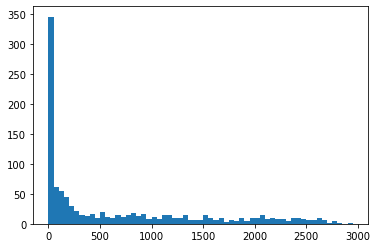

In [468]:
plt.hist(h['pitches'],bins = np.arange(0,3000,50));

In [469]:
#removing players that have less than 250 pitches or na values
h = h[h['pitches']>250]

h = h.dropna()

In [470]:
h_names = h['player_name']
h_ids = h['player_id']

In [471]:
columns = ['total_pitches',
       'ba', 'iso', 'babip', 'slg', 'woba', 'xwoba', 'xba', 'hits', 'abs',
       'launch_speed', 'launch_angle', 'spin_rate', 'velocity',
       'effective_speed', 'whiffs', 'swings', 'takes', 'eff_min_vel','pos3_int_start_distance',
       'pos4_int_start_distance', 'pos5_int_start_distance',
       'pos6_int_start_distance', 'pos7_int_start_distance',
       'pos8_int_start_distance', 'pos9_int_start_distance']


h = h[columns]


#### Finally: Clustering!

In [472]:
# Scale the Data!
scaler = StandardScaler()
h_scaled = pd.DataFrame(scaler.fit_transform(h))
h_scaled.columns = columns
h_scaled.head()

,total_pitches,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,2.178200,0.691117,1.858713,-0.237115,1.670118,1.322259,0.512604,0.223190,2.063869,2.111763,0.554020,1.367945,0.129185,-0.038465,-0.089802,1.303793,1.984836,2.274756,-0.048993,-1.002094,0.150929,0.252753,-1.004161,0.346795,0.648247,-0.443346
1,2.033638,0.066277,0.278692,-0.023265,0.232188,0.667503,0.557103,-0.062779,1.221121,1.538880,-0.118023,1.384655,-1.198868,0.355420,0.415459,0.774720,1.302673,2.603070,0.322630,1.006016,1.107901,0.098877,0.998294,-0.268661,0.418716,0.016154
2,1.998179,0.883375,-0.910395,0.703827,-0.223740,0.181716,-0.199375,0.652143,1.979594,1.912762,-0.594054,-0.453371,-1.025643,0.552363,0.362273,0.319717,1.745935,2.149445,-0.048993,1.508043,-0.566800,-1.286007,1.498908,-1.807301,-1.188005,0.322488
3,1.976358,0.402729,1.190869,-0.130190,1.050522,0.730866,1.002090,0.709336,1.726770,1.918792,0.442013,0.432223,-0.852419,-1.220123,-0.754619,2.372521,1.912878,1.963985,0.136818,-0.751080,-0.327557,0.560506,-1.504774,0.500659,0.189184,-0.443346
4,1.974994,0.835311,1.793557,-0.386810,1.693499,1.554591,1.580573,0.795127,1.642495,1.587123,1.058053,0.632735,-0.275005,-0.826237,-0.462100,1.473097,1.947418,1.933910,0.136818,1.508043,3.500330,1.483762,0.998294,0.346795,1.336842,0.935155


In [473]:
kmeans_h = KMeans(n_clusters = 5)
kmeans_h.fit(h_scaled)
clusters = kmeans_h.predict(h_scaled)
h_scaled["Cluster"] = clusters


#### Create PCA on the Data & Visualize

In [474]:
pca_2d_h = PCA(n_components=2)
pca_3d_h = PCA(n_components = 3)

PCs_2d_h = pd.DataFrame(pca_2d.fit_transform(h_scaled.drop(["Cluster"], axis=1)))
PCs_3d_h = pd.DataFrame(pca_3d.fit_transform(h_scaled.drop(["Cluster"], axis=1)))
PCs_2d_h.columns = ["PC1_2d", "PC2_2d"]

PCs_3d_h.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]


In [475]:
plotX_h = pd.concat([h_scaled,PCs_2d_h,PCs_3d_h], axis=1, join='inner')
plotX_h['Name'] = h_names
plotX_h["player_id"] = h_ids
plotX_h.head()

,total_pitches,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance,Cluster,PC1_2d,PC2_2d,PC1_3d,PC2_3d,PC3_3d,Name,player_id
0,2.178200,0.691117,1.858713,-0.237115,1.670118,1.322259,0.512604,0.223190,2.063869,2.111763,0.554020,1.367945,0.129185,-0.038465,-0.089802,1.303793,1.984836,2.274756,-0.048993,-1.002094,0.150929,0.252753,-1.004161,0.346795,0.648247,-0.443346,1,-5.197340,-1.385546,-5.197340,-1.385544,0.358914,"Semien, Marcus",543760
1,2.033638,0.066277,0.278692,-0.023265,0.232188,0.667503,0.557103,-0.062779,1.221121,1.538880,-0.118023,1.384655,-1.198868,0.355420,0.415459,0.774720,1.302673,2.603070,0.322630,1.006016,1.107901,0.098877,0.998294,-0.268661,0.418716,0.016154,1,-3.380968,0.804439,-3.380968,0.804440,-2.218198,"Grossman, Robbie",543257
2,1.998179,0.883375,-0.910395,0.703827,-0.223740,0.181716,-0.199375,0.652143,1.979594,1.912762,-0.594054,-0.453371,-1.025643,0.552363,0.362273,0.319717,1.745935,2.149445,-0.048993,1.508043,-0.566800,-1.286007,1.498908,-1.807301,-1.188005,0.322488,0,-2.191531,-0.914148,-2.191531,-0.914147,-4.955013,"Crawford, J.P.",641487
3,1.976358,0.402729,1.190869,-0.130190,1.050522,0.730866,1.002090,0.709336,1.726770,1.918792,0.442013,0.432223,-0.852419,-1.220123,-0.754619,2.372521,1.912878,1.963985,0.136818,-0.751080,-0.327557,0.560506,-1.504774,0.500659,0.189184,-0.443346,1,-4.734367,-1.566764,-4.734367,-1.566764,0.371232,"Haniger, Mitch",571745
4,1.974994,0.835311,1.793557,-0.386810,1.693499,1.554591,1.580573,0.795127,1.642495,1.587123,1.058053,0.632735,-0.275005,-0.826237,-0.462100,1.473097,1.947418,1.933910,0.136818,1.508043,3.500330,1.483762,0.998294,0.346795,1.336842,0.935155,1,-6.216826,2.864033,-6.216826,2.864035,-0.446729,"Olson, Matt",621566


In [476]:
init_notebook_mode(connected=True)

In [477]:
cluster0_h = plotX_h[plotX_h["Cluster"] == 0]
cluster1_h = plotX_h[plotX_h["Cluster"] == 1]
cluster2_h = plotX_h[plotX_h["Cluster"] == 2]
cluster3_h = plotX_h[plotX_h["Cluster"] == 3]
cluster4_h = plotX_h[plotX_h["Cluster"] == 4]


In [478]:
base = alt.Chart(plotX_h).mark_circle(size = 60).encode(
    x = "PC1_2d",
    y = "PC2_2d",
    color = 'Cluster:N',
    tooltip = ["Name"]
).interactive()


base

alt.Chart(...)

#### Save Clusters

In [479]:
h_clu = np.array(plotX_h["Cluster"])
h_clu

h_clusts_ids_250 = pd.DataFrame()
h_clusts_ids_250['cluster'] = h_clu
h_clusts_ids_250['player_id'] = h_ids



h_clusts_ids_250.head()

,cluster,player_id
0,1,543760
1,1,543257
2,0,641487
3,1,571745
4,1,621566


In [480]:
h_clusts_ids_250.to_csv("/content/drive/MyDrive/Final Project 207/datasets/cluster/hitter_clusters/clusters_all.csv")

## **Create X-Matrix** 

#### Re-Load the Data

In [481]:
## Output from Clustering Hitters
hitters = pd.read_csv('/content/drive/MyDrive/Final Project 207/datasets/cluster/hitter_clusters/clusters_all.csv')
hitters = hitters.dropna()
print(hitters.shape)
hitters.head()

(512, 3)


,Unnamed: 0,cluster,player_id
0,0,1,543760
1,1,1,543257
2,2,0,641487
3,3,1,571745
4,4,1,621566


In [482]:
## Output from Clustering Pitchers
pitchers = pd.read_csv('/content/drive/MyDrive/Final Project 207/datasets/cluster/pitcher_clusters_all.csv')
pitchers = pitchers.dropna()
print(pitchers.shape)
pitchers.head()

(735, 3)


,Unnamed: 0,cluster,player_id
0,0,2,554430
1,1,2,641816
2,2,2,622491
3,3,2,621111
4,4,2,592662


In [483]:
## All 2021 events (from first Data Pull)
events = pd.read_csv('/content/drive/MyDrive/Final Project 207/datasets/events_2021.csv')
events.shape


(181348, 23)

In [484]:
relevent_colums = [ 
       'batter', 'pitcher', 'h_hits', 'p_throws', 'inning',
       'outs_when_up', 'on_1b', 'on_2b', 'on_3b',
       'if_fielding_alignment', 'of_fielding_alignment', 'events', 'score_diff_offense']

In [485]:
## This is the relvant "game state" of every plate appearance/event
rel_events = events[relevent_colums]
rel_events.head()

,batter,pitcher,h_hits,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,events,score_diff_offense
0,596019,519293,R,L,9,2,0,0,0,Infield shift,Strategic,field_out,-5
1,607043,519293,L,L,9,1,0,0,0,Standard,Standard,field_out,-5
2,641645,519293,L,L,9,0,0,0,0,Standard,Standard,strikeout,-5
3,594807,607229,R,R,8,2,0,0,0,Infield shift,Standard,field_out,5
4,663586,607229,R,R,8,1,0,0,0,Infield shift,Standard,strikeout,5


#### Merge Clustering Data with Game State Data
store the merged gamestate w/ clustering DF as "rf_predictors.csv"

In [486]:
merged_hitters = rel_events.merge(hitters, left_on = "batter", right_on = "player_id", how = "right")
merged_hitters.head()

,batter,pitcher,h_hits,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,events,score_diff_offense,Unnamed: 0,cluster,player_id
0,543760,641632,R,R,8,0,1,0,0,Standard,Standard,strikeout,8,0,1,543760
1,543760,607216,R,R,5,2,0,0,0,Standard,Standard,home_run,9,0,1,543760
2,543760,621098,R,R,3,2,0,0,0,Standard,Standard,field_out,8,0,1,543760
3,543760,650959,R,R,2,1,1,0,0,Standard,Standard,field_out,3,0,1,543760
4,543760,669145,R,L,1,0,0,0,0,Standard,Standard,single,1,0,1,543760


In [487]:
merged_both = merged_hitters.merge(pitchers, left_on = 'pitcher', right_on = 'player_id', how = 'right')
merged_both = merged_both.dropna()


rel_col = ['h_hits', 'p_throws', 'inning', 'outs_when_up',
       'on_1b', 'on_2b', 'on_3b', 'if_fielding_alignment',
       'of_fielding_alignment', 'events', 'score_diff_offense',
       'cluster_x', 'cluster_y','player_id_x','player_id_y']
 

merged_both = merged_both[rel_col]
merged_both.head()

final_columns = ['h_hits', 'p_throws', 'inning', 'outs_when_up',
       'on_1b', 'on_2b', 'on_3b', 'if_fielding_alignment',
       'of_fielding_alignment', 'score_diff_offense',
       'cluster_x', 'cluster_y']


## Save the Events, Hitter_id, Pitcher_ID for later
events = merged_both['events']
hits = merged_both['player_id_x']
pitches = merged_both['player_id_y']


merged_both = merged_both[final_columns]

# cluster_x = batter cluster
# cluster_y is pitcher cluster
merged_both = merged_both.rename(columns = {'cluster_x': 'cluster_hitter', 'cluster_y': 'cluster_pitcher'})


merged_both.to_csv('rf_predictors.csv')
print(merged_both.shape)
merged_both.head()

(170243, 12)


,h_hits,p_throws,inning,outs_when_up,on_1b,on_2b,on_3b,if_fielding_alignment,of_fielding_alignment,score_diff_offense,cluster_hitter,cluster_pitcher
0,R,R,7,1,0,0,0,Standard,Standard,-1,1,2
1,R,R,4,2,0,0,0,Standard,Standard,0,1,2
2,R,R,1,2,0,0,0,Standard,Standard,0,1,2
3,L,R,6,0,1,0,0,Standard,Standard,2,1,2
4,L,R,3,1,1,0,0,Standard,Standard,2,1,2


#### Create OneHot encoding of merged_both DF (gamestate + Player Clusters)

In [488]:
## Create oneHot encoding of merged_both
encoded_test = pd.get_dummies(merged_both)

print(encoded_test.shape)
encoded_test.head()

(170243, 18)


,inning,outs_when_up,on_1b,on_2b,on_3b,score_diff_offense,cluster_hitter,cluster_pitcher,h_hits_L,h_hits_R,p_throws_L,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic
0,7,1,0,0,0,-1,1,2,0,1,0,1,0,1,0,0,1,0
1,4,2,0,0,0,0,1,2,0,1,0,1,0,1,0,0,1,0
2,1,2,0,0,0,0,1,2,0,1,0,1,0,1,0,0,1,0
3,6,0,1,0,0,2,1,2,1,0,0,1,0,1,0,0,1,0
4,3,1,1,0,0,2,1,2,1,0,0,1,0,1,0,0,1,0


In [489]:
encoded_columns = [ 'outs_when_up', 'on_1b', 'on_2b', 'on_3b',
       'score_diff_offense', 'cluster_hitter', 'cluster_pitcher',
       'h_hits_R', 'p_throws_R',
       'if_fielding_alignment_Infield shift', 'if_fielding_alignment_Standard',
       'of_fielding_alignment_Standard', 'of_fielding_alignment_Strategic']

In [490]:
encoded_test[encoded_columns]

,outs_when_up,on_1b,on_2b,on_3b,score_diff_offense,cluster_hitter,cluster_pitcher,h_hits_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_Standard,of_fielding_alignment_Strategic
0,1,0,0,0,-1,1,2,1,1,0,1,1,0
1,2,0,0,0,0,1,2,1,1,0,1,1,0
2,2,0,0,0,0,1,2,1,1,0,1,1,0
3,0,1,0,0,2,1,2,0,1,0,1,1,0
4,1,1,0,0,2,1,2,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171118,2,0,0,0,3,3,3,1,1,0,1,1,0
171119,0,0,0,0,-2,0,3,0,1,0,0,0,0
171120,1,1,0,0,8,4,3,0,1,1,0,1,0
171121,1,0,0,0,1,3,3,1,1,0,0,0,0


In [491]:
## Make outs OneHot-able 
encoded_test['outs_when_up'] = encoded_test['outs_when_up'].map(str)

In [492]:
## Make clusters OneHot-able 
encoded_test['cluster_hitter'] = encoded_test['cluster_hitter'].map(str)
encoded_test['cluster_pitcher'] = encoded_test['cluster_pitcher'].map(str)

encoded_test

,inning,outs_when_up,on_1b,on_2b,on_3b,score_diff_offense,cluster_hitter,cluster_pitcher,h_hits_L,h_hits_R,p_throws_L,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic
0,7,1,0,0,0,-1,1,2,0,1,0,1,0,1,0,0,1,0
1,4,2,0,0,0,0,1,2,0,1,0,1,0,1,0,0,1,0
2,1,2,0,0,0,0,1,2,0,1,0,1,0,1,0,0,1,0
3,6,0,1,0,0,2,1,2,1,0,0,1,0,1,0,0,1,0
4,3,1,1,0,0,2,1,2,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171118,8,2,0,0,0,3,3,3,0,1,0,1,0,1,0,0,1,0
171119,9,0,0,0,0,-2,0,3,1,0,0,1,0,0,1,1,0,0
171120,7,1,1,0,0,8,4,3,1,0,0,1,1,0,0,0,1,0
171121,7,1,0,0,0,1,3,3,0,1,0,1,0,0,1,1,0,0


#### Make Final X-Matrix DF

In [493]:
## Create Final DF
final = pd.get_dummies(encoded_test)

## Add Columns For the Outcome & Hitter & Pitcher IDs
final['hitter'] = hits
final['pitcher'] = pitches
final['outcome'] = events

final.head()

,inning,on_1b,on_2b,on_3b,score_diff_offense,h_hits_L,h_hits_R,p_throws_L,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,outs_when_up_0,outs_when_up_1,outs_when_up_2,cluster_hitter_0,cluster_hitter_1,cluster_hitter_2,cluster_hitter_3,cluster_hitter_4,cluster_pitcher_0,cluster_pitcher_1,cluster_pitcher_2,cluster_pitcher_3,cluster_pitcher_4,hitter,pitcher,outcome
0,7,0,0,0,-1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out
1,4,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out
2,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out
3,6,1,0,0,2,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,518692,554430,single
4,3,1,0,0,2,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,518692,554430,field_out


In [494]:
rel_final_col = [ 'on_1b', 'on_2b', 'on_3b', 'score_diff_offense','h_hits_L', 'h_hits_R', 'p_throws_L', 'p_throws_R',
       'if_fielding_alignment_Infield shift', 'if_fielding_alignment_Standard',
       'if_fielding_alignment_Strategic',
       'of_fielding_alignment_4th outfielder',
       'of_fielding_alignment_Standard', 'of_fielding_alignment_Strategic',
       'outs_when_up_0', 'outs_when_up_1', 'outs_when_up_2',
       'cluster_hitter_0', 'cluster_hitter_1', 'cluster_hitter_2',
       'cluster_hitter_3', 'cluster_hitter_4', 'cluster_pitcher_0',
       'cluster_pitcher_1', 'cluster_pitcher_2', 'cluster_pitcher_3',
       'cluster_pitcher_4', 'hitter', 'pitcher', 'outcome']
final = final[rel_final_col]
final.head()

,on_1b,on_2b,on_3b,score_diff_offense,h_hits_L,h_hits_R,p_throws_L,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,outs_when_up_0,outs_when_up_1,outs_when_up_2,cluster_hitter_0,cluster_hitter_1,cluster_hitter_2,cluster_hitter_3,cluster_hitter_4,cluster_pitcher_0,cluster_pitcher_1,cluster_pitcher_2,cluster_pitcher_3,cluster_pitcher_4,hitter,pitcher,outcome
0,0,0,0,-1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out
1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out
2,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out
3,1,0,0,2,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,518692,554430,single
4,1,0,0,2,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,518692,554430,field_out


In [495]:
final.to_csv('/content/drive/MyDrive/Final Project 207/datasets/X_MATRIX_WITH_NAMES_FINAL.csv')

## **Checkout the League Averages** 

#### Create DF that is our final version of the X-matrix

In [531]:
data = pd.read_csv("/content/drive/MyDrive/Final Project 207/datasets/X_MATRIX_WITH_NAMES_FINAL.csv")

# save outcome , hitter , and pitcher
y = data[['outcome']]
matrix_hitter = data[["hitter"]]
matrix_pitcher = data[["pitcher"]]

X = data[data.columns.drop({'outcome', "h_hits_L", "p_throws_L", "if_fielding_alignment_Strategic", "of_fielding_alignment_Strategic", "outs_when_up_2",  "cluster_hitter_4", "cluster_pitcher_4", "hitter", "pitcher"})]
print(X.shape)
print(y.shape)
X.head()

(170243, 21)
(170243, 1)


,Unnamed: 0,on_1b,on_2b,on_3b,score_diff_offense,h_hits_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,outs_when_up_0,outs_when_up_1,cluster_hitter_0,cluster_hitter_1,cluster_hitter_2,cluster_hitter_3,cluster_pitcher_0,cluster_pitcher_1,cluster_pitcher_2,cluster_pitcher_3
0,0,0,0,0,-1,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
1,1,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
2,2,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,3,1,0,0,2,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0
4,4,1,0,0,2,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0


#### Train / Test / Val Split

In [532]:
## X_train == our training dataset
## X_val == our validation training set
## X_test = our testing dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)

test_size = 0.5

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(136194, 21) (136194, 1)
(17024, 21) (17024, 1)
(17025, 21) (17025, 1)


#### Creating "Average" Table

In [533]:
## columns we want to keep 
top_outcomes = ["single", "double", "triple", "home_run", "walk", "hit_by_pitch","sac_fly",  "sac_bunt", "field_error", "strikeout", "field_out", "force_out", "fielders_choice", "grounded_into_double_play", "double_play" ]

## Create Averages Table -- Filter out rare events
outcome_average = y["outcome"].value_counts().sort_index()/len(y)
averages = pd.DataFrame(y["outcome"].value_counts().sort_index()/len(y)).reindex(top_outcomes)
averages

,outcome
single,0.140070
double,0.044160
triple,0.003771
home_run,0.033581
walk,0.084374
hit_by_pitch,0.011801
sac_fly,0.006356
sac_bunt,0.002003
field_error,0.006920
strikeout,0.225672


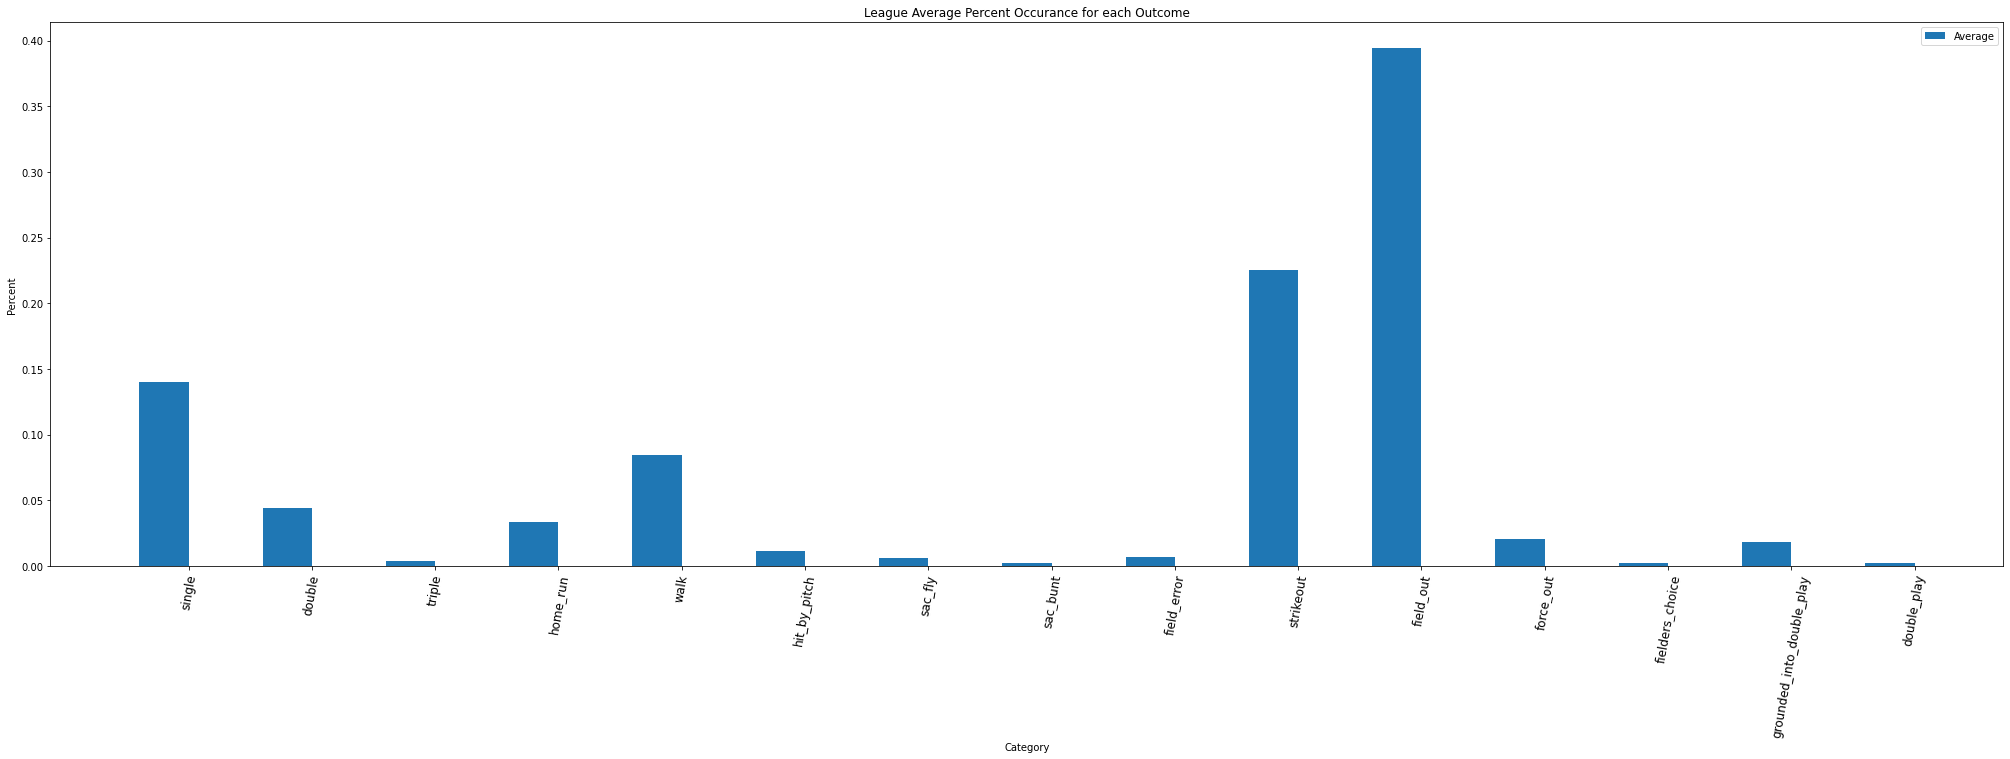

In [534]:
## Display League Average in a Chart
figure(figsize = (35, 10))

X = top_outcomes
avg = averages.outcome.values
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, avg, 0.4, label = 'Average')
plt.xticks(X_axis, X)
plt.xlabel("Category")
plt.ylabel("Percent")
plt.title("League Average Percent Occurance for each Outcome")
plt.xticks(rotation = 80, size = 12) 
plt.legend()
plt.show()

## **Present 1st Model in Detail**
Naive Bayes

#### Train Naive Bayes

In [535]:
clf = GaussianNB() 
clf.fit(X_train, np.ravel(y_train))

GaussianNB()

In [536]:

clf.predict_proba(X_train)[0]

array([4.26242345e-04, 8.03849877e-04, 7.22259022e-05, 1.70545258e-05,
       4.27107252e-02, 2.24575995e-03, 6.97464854e-03, 3.91308047e-01,
       2.35030760e-03, 2.06968444e-03, 1.67731464e-02, 1.55264244e-05,
       1.47837920e-02, 1.24426425e-02, 3.19052203e-02, 2.35659109e-04,
       0.00000000e+00, 3.19150241e-05, 9.17003794e-05, 5.91558483e-06,
       1.50603262e-05, 2.37174969e-03, 8.27400301e-03, 1.20782078e-04,
       1.33627218e-01, 0.00000000e+00, 2.30842851e-01, 5.34395296e-04,
       3.61648459e-03, 1.59611563e-04, 9.47222177e-02, 4.51564066e-04])

In [537]:
## Creat DF of predicted outcomes in each Matchup in our train set
class_proba = pd.DataFrame(clf.predict_proba(X_train), columns=clf.classes_)
class_proba


,catcher_interf,caught_stealing_2b,caught_stealing_3b,caught_stealing_home,double,double_play,field_error,field_out,fielders_choice,fielders_choice_out,force_out,game_advisory,grounded_into_double_play,hit_by_pitch,home_run,other_out,passed_ball,pickoff_1b,pickoff_2b,pickoff_3b,pickoff_caught_stealing_2b,sac_bunt,sac_fly,sac_fly_double_play,single,stolen_base_2b,strikeout,strikeout_double_play,triple,triple_play,walk,wild_pitch
0,0.000426,0.000804,7.222590e-05,1.705453e-05,0.042711,0.002246,0.006975,0.391308,0.002350,0.002070,0.016773,1.552642e-05,0.014784,0.012443,0.031905,0.000236,0.0,3.191502e-05,9.170038e-05,5.915585e-06,1.506033e-05,2.371750e-03,0.008274,0.000121,0.133627,0.0,0.230843,0.000534,0.003616,1.596116e-04,0.094722,4.515641e-04
1,0.000131,0.000003,1.056624e-08,7.290587e-07,0.037806,0.000499,0.007616,0.389687,0.001125,0.000078,0.024107,9.054740e-04,0.024090,0.013042,0.036149,0.000033,0.0,1.623658e-07,2.531137e-11,1.437124e-14,5.744276e-11,7.307681e-07,0.002611,0.000050,0.146392,0.0,0.229151,0.000001,0.002156,5.846937e-10,0.084364,1.706271e-11
2,0.000333,0.000415,1.147060e-05,1.834419e-06,0.044119,0.001856,0.007430,0.387086,0.002103,0.001515,0.018740,1.072711e-04,0.016994,0.015354,0.032548,0.000217,0.0,6.223816e-05,2.368870e-08,3.305790e-08,6.707025e-06,1.515091e-03,0.007270,0.000145,0.142978,0.0,0.217529,0.000194,0.003631,8.439786e-07,0.097817,1.799398e-05
3,0.000377,0.000724,5.226184e-05,2.750620e-05,0.044780,0.002545,0.006621,0.394061,0.002423,0.001299,0.022951,1.745951e-10,0.022157,0.010854,0.033862,0.000159,0.0,4.254782e-05,1.302089e-06,4.827872e-07,2.563589e-06,1.407400e-03,0.004963,0.000064,0.141910,0.0,0.228759,0.000873,0.003394,4.310756e-06,0.075685,1.509405e-06
4,0.000488,0.001300,8.939152e-05,2.120527e-05,0.045208,0.002337,0.007131,0.388408,0.002319,0.001606,0.020741,6.688968e-07,0.017348,0.012272,0.035732,0.000277,0.0,2.376140e-05,1.664088e-04,2.641031e-05,4.733884e-05,3.523830e-03,0.005516,0.000070,0.136642,0.0,0.222357,0.001034,0.003863,1.561590e-04,0.091183,1.130903e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136189,0.000445,0.000955,1.057439e-04,2.279831e-05,0.044775,0.002248,0.007232,0.391517,0.002189,0.002390,0.016840,6.655115e-06,0.013559,0.012716,0.033350,0.000306,0.0,1.856402e-05,2.733038e-04,4.646430e-05,5.546238e-05,4.088186e-03,0.008212,0.000136,0.135914,0.0,0.221882,0.000617,0.004033,2.503437e-04,0.095456,3.606349e-04
136190,0.000411,0.000941,2.888676e-05,2.391393e-06,0.043759,0.001967,0.007439,0.391214,0.002023,0.001756,0.017479,9.394117e-05,0.014958,0.014718,0.031400,0.000298,0.0,3.176000e-05,1.074882e-06,1.325773e-06,5.628554e-05,4.034974e-03,0.005834,0.000094,0.139088,0.0,0.217450,0.000428,0.003923,6.322567e-06,0.100471,9.393191e-05
136191,0.000117,0.000020,1.980664e-07,5.943067e-06,0.040604,0.000887,0.006532,0.417089,0.001073,0.000160,0.018547,7.860155e-13,0.019064,0.009684,0.032909,0.000033,0.0,1.039546e-06,1.203461e-11,2.995062e-12,2.267882e-10,1.133691e-05,0.002129,0.000029,0.146090,0.0,0.235203,0.000017,0.002770,1.515234e-10,0.067023,2.092758e-12
136192,0.000224,0.001397,2.130891e-05,2.383260e-05,0.046186,0.002156,0.006354,0.423248,0.001457,0.001363,0.014798,1.696457e-20,0.013504,0.009682,0.031407,0.000123,0.0,1.281423e-05,1.627528e-11,5.297393e-07,1.275708e-06,2.095208e-03,0.003468,0.000039,0.142132,0.0,0.226778,0.001279,0.004246,2.244774e-11,0.068005,1.755931e-11


In [503]:
print("range of Field Out Probability: ", max(class_proba["field_out"]), min(class_proba["field_out"]))
print("range of Home Run Probability: ", max(class_proba["home_run"]), min(class_proba["home_run"]))

range of Field Out Probability:  0.4302592575359269 0.03295987343389004
range of Home Run Probability:  0.045288668439839794 0.005108858455930308


#### Creating the Outcomes We Want & Visualizing

In [538]:
## Filter out Super Rare outcomes
top_outcomes = ["single", "double", "triple", "home_run", "walk", "hit_by_pitch","sac_fly",  "sac_bunt", "field_error", "strikeout", "field_out", "force_out", "fielders_choice", "grounded_into_double_play", "double_play" ]
top_class_proba = class_proba[top_outcomes]
top_class_proba

,single,double,triple,home_run,walk,hit_by_pitch,sac_fly,sac_bunt,field_error,strikeout,field_out,force_out,fielders_choice,grounded_into_double_play,double_play
0,0.133627,0.042711,0.003616,0.031905,0.094722,0.012443,0.008274,2.371750e-03,0.006975,0.230843,0.391308,0.016773,0.002350,0.014784,0.002246
1,0.146392,0.037806,0.002156,0.036149,0.084364,0.013042,0.002611,7.307681e-07,0.007616,0.229151,0.389687,0.024107,0.001125,0.024090,0.000499
2,0.142978,0.044119,0.003631,0.032548,0.097817,0.015354,0.007270,1.515091e-03,0.007430,0.217529,0.387086,0.018740,0.002103,0.016994,0.001856
3,0.141910,0.044780,0.003394,0.033862,0.075685,0.010854,0.004963,1.407400e-03,0.006621,0.228759,0.394061,0.022951,0.002423,0.022157,0.002545
4,0.136642,0.045208,0.003863,0.035732,0.091183,0.012272,0.005516,3.523830e-03,0.007131,0.222357,0.388408,0.020741,0.002319,0.017348,0.002337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136189,0.135914,0.044775,0.004033,0.033350,0.095456,0.012716,0.008212,4.088186e-03,0.007232,0.221882,0.391517,0.016840,0.002189,0.013559,0.002248
136190,0.139088,0.043759,0.003923,0.031400,0.100471,0.014718,0.005834,4.034974e-03,0.007439,0.217450,0.391214,0.017479,0.002023,0.014958,0.001967
136191,0.146090,0.040604,0.002770,0.032909,0.067023,0.009684,0.002129,1.133691e-05,0.006532,0.235203,0.417089,0.018547,0.001073,0.019064,0.000887
136192,0.142132,0.046186,0.004246,0.031407,0.068005,0.009682,0.003468,2.095208e-03,0.006354,0.226778,0.423248,0.014798,0.001457,0.013504,0.002156


In [505]:
averages = pd.DataFrame(y["outcome"].value_counts().sort_index()/len(y)).reindex(top_outcomes)

def predicted_percent_output(row):
	row_num = pd.DataFrame(top_class_proba.iloc[row])
	output = row_num.join(averages).rename(columns = {row: "predicted_percent", "outcome": "average"})
	return output['predicted_percent'].tolist()

pred_perc = [predicted_percent_output(row) for row in range(len(top_class_proba))]

pred_perc = pd.DataFrame(pred_perc)
pred_perc.columns = top_outcomes
pred_perc

,single,double,triple,home_run,walk,hit_by_pitch,sac_fly,sac_bunt,field_error,strikeout,field_out,force_out,fielders_choice,grounded_into_double_play,double_play
0,0.140399,0.044007,0.004164,0.031557,0.074305,0.009849,0.004354,0.002386,0.006458,0.228206,0.414115,0.015992,0.002106,0.015494,0.002270
1,0.138768,0.042507,0.003488,0.033604,0.094672,0.013855,0.004734,0.001405,0.007090,0.226332,0.392819,0.018354,0.002082,0.015920,0.001716
2,0.142250,0.043151,0.004037,0.031879,0.069961,0.009885,0.003381,0.001188,0.006199,0.231433,0.409390,0.020914,0.002140,0.019388,0.002222
3,0.140162,0.041282,0.003260,0.032267,0.086287,0.012554,0.005444,0.000346,0.007038,0.233838,0.395089,0.020246,0.002149,0.016864,0.001494
4,0.135741,0.043610,0.004037,0.032835,0.081698,0.010169,0.004646,0.002552,0.006568,0.230031,0.409788,0.015216,0.002092,0.014360,0.002179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17019,0.141956,0.043773,0.003548,0.032439,0.078393,0.011425,0.003832,0.002174,0.007227,0.227481,0.406992,0.017810,0.002158,0.016034,0.001836
17020,0.139190,0.043288,0.003618,0.030601,0.100270,0.014968,0.007413,0.004309,0.006869,0.217638,0.373648,0.026569,0.002794,0.020621,0.002508
17021,0.144353,0.043288,0.003498,0.034450,0.069738,0.009997,0.003858,0.000526,0.006560,0.233091,0.409149,0.017700,0.002122,0.017863,0.001956
17022,0.133613,0.043003,0.003690,0.034611,0.092628,0.011742,0.004725,0.003199,0.007033,0.229110,0.398713,0.015810,0.002072,0.013625,0.001870


Hitter:  rafael devers
Pitcher:  zack wheeler
Game State important too


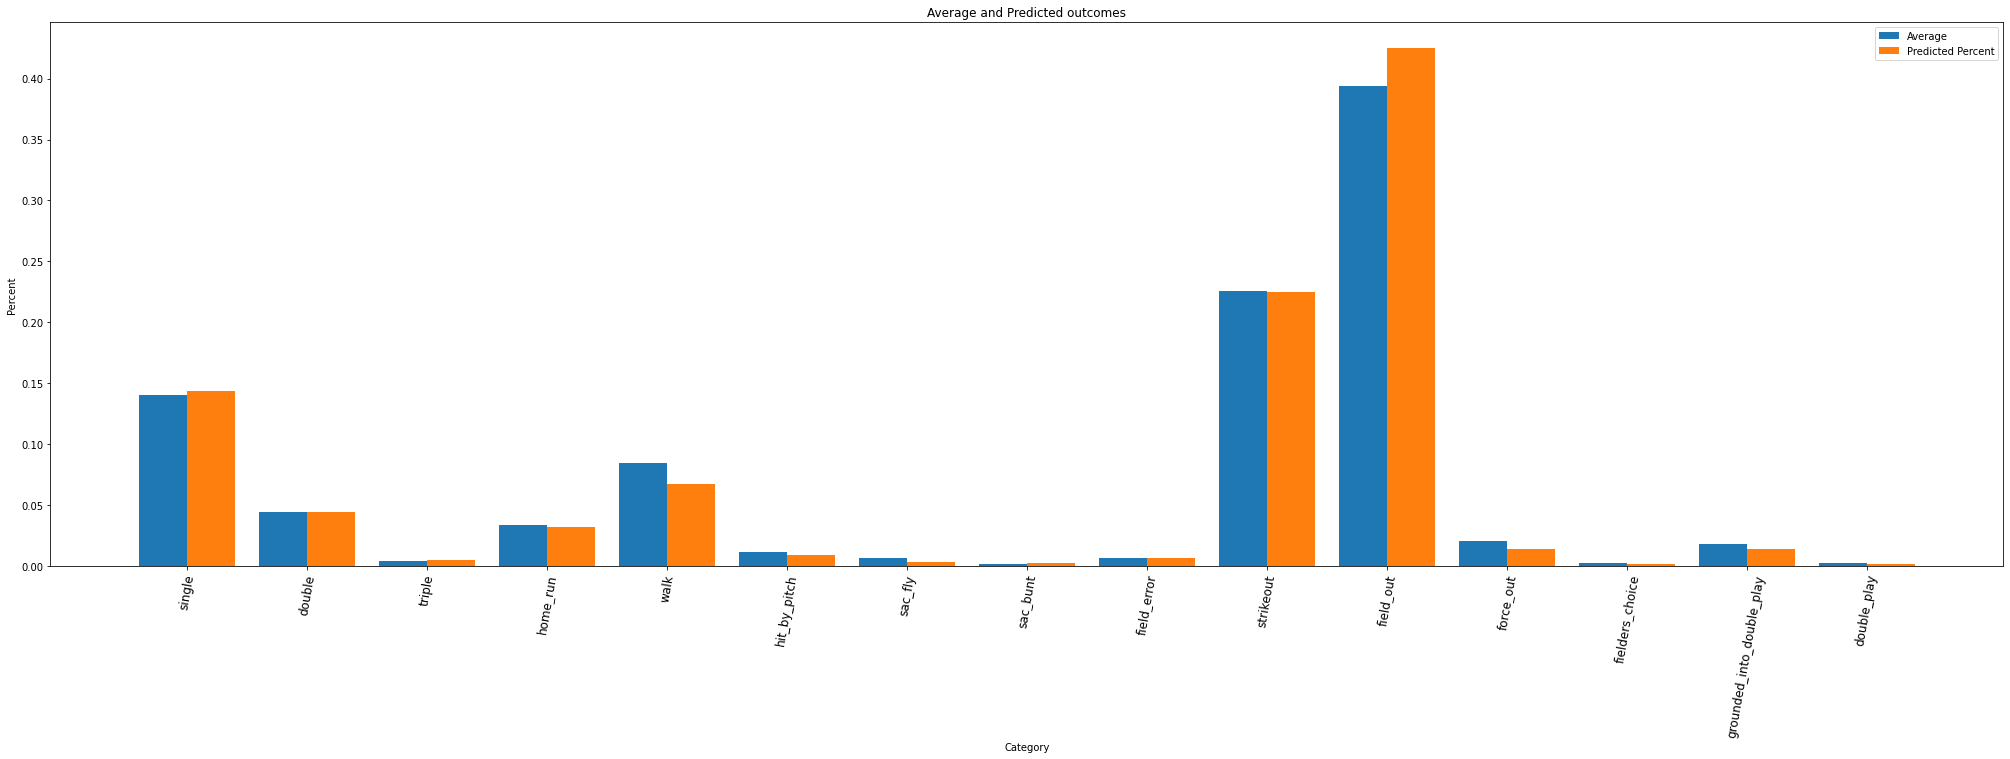

In [543]:
figure(figsize = (35, 10))

## Must choose the Row / players you want to look at
row_num = 90
row = pred_perc.loc[row_num]

mydf=(playerid_reverse_lookup([matrix_hitter.iloc[row_num].values], key_type='mlbam'))
hitterfirstname=(mydf.iloc[0][1])
hitterlastname=(mydf.iloc[0][0])
hittername=hitterfirstname+" "+hitterlastname
mydf2=(playerid_reverse_lookup([ matrix_pitcher.iloc[row_num].values], key_type='mlbam'))
pitcherfirstname=(mydf2.iloc[0][1])
pitcherlastname=(mydf2.iloc[0][0])
pitchername=pitcherfirstname+" "+pitcherlastname

print("Hitter: ", hittername)
print("Pitcher: ", pitchername)
print("Game State important too") #, X_train.iloc[row_num].values)

X = top_outcomes
avg = averages.outcome.values
pred = row
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, avg, 0.4, label = 'Average')
plt.bar(X_axis + 0.2, pred, 0.4, label = 'Predicted Percent')
  
plt.xticks(X_axis, X)
plt.xlabel("Category")
plt.ylabel("Percent")
plt.title("Average and Predicted outcomes")
plt.xticks(rotation = 80, size = 12) 
plt.legend()
plt.show()

## **Compare to Test Set?** 
Doesn't really work for our Naive Bayes Outcomes Model...

#### What does our y_test look like?


In [507]:
y_test

,outcome
142591,field_out
152927,strikeout
18300,single
118583,field_out
58054,strikeout
...,...
77801,field_out
17782,single
17019,home_run
69248,field_out


#### What if we try a different style of model?
Predict a season-long Metric (ops %) instead of a single event

#### Load OPS Data

In [508]:
ops_data = pd.read_csv("/content/drive/MyDrive/Final Project 207/datasets/X_MATRIX_WITH_NAMES_FINAL.csv")

In [509]:
## change the outcome column to a metric -- represents the points you get in OPS for each event
y_convert = {"single": 2, "double": 3, "triple": 4, "home_run":5, "walk" : 1, "hit_by_pitch": 1, 
             "double_play": 0, "field_error": 0, "field_out": 0, "fielders_choice": 0, 
             "fielders_choice_out": 0, "force_out": 0, "grounded_into_double_play": 0, 
             "other_out": 0, "sac_fly": 0, "sac_fly_double_play": 0, "strikeout": 0, 
             "strikeout_double_play": 0, "triple_play": 0}
  
at_bats = list(y_convert.keys())

ab_data = ops_data[ops_data["outcome"].isin(at_bats)]
ab_data["outcome_val"] = ab_data["outcome"].replace(y_convert)
ab_data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,on_1b,on_2b,on_3b,score_diff_offense,h_hits_L,h_hits_R,p_throws_L,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic,outs_when_up_0,outs_when_up_1,outs_when_up_2,cluster_hitter_0,cluster_hitter_1,cluster_hitter_2,cluster_hitter_3,cluster_hitter_4,cluster_pitcher_0,cluster_pitcher_1,cluster_pitcher_2,cluster_pitcher_3,cluster_pitcher_4,hitter,pitcher,outcome,outcome_val
0,0,0,0,0,-1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out,0
1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out,0
2,2,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,502671,554430,field_out,0
3,3,1,0,0,2,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,518692,554430,single,2
4,4,1,0,0,2,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,518692,554430,field_out,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170238,171118,0,0,0,3,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,672386,623433,field_out,0
170239,171119,0,0,0,-2,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,650331,623433,home_run,5
170240,171120,1,0,0,8,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,591971,623433,walk,1
170241,171121,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,572863,623433,home_run,5


#### Create Train & Test Sets

In [510]:
X = ab_data[ab_data.columns.drop({'Unnamed: 0', 'score_diff_offense', 'outcome', 'outcome_val', "h_hits_L", "p_throws_L", "if_fielding_alignment_Strategic", "of_fielding_alignment_Strategic", "outs_when_up_2",  "cluster_hitter_4", "cluster_pitcher_4"})]
y = ab_data[['outcome_val']]
print(X.shape)
print(y.shape)
X.head()

(169657, 21)
(169657, 1)


,on_1b,on_2b,on_3b,h_hits_R,p_throws_R,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,outs_when_up_0,outs_when_up_1,cluster_hitter_0,cluster_hitter_1,cluster_hitter_2,cluster_hitter_3,cluster_pitcher_0,cluster_pitcher_1,cluster_pitcher_2,cluster_pitcher_3,hitter,pitcher
0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,502671,554430
1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,502671,554430
2,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,502671,554430
3,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,518692,554430
4,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,518692,554430


In [511]:
## X_train == our training dataset
## X_val == our validation training set
## X_test = our testing dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)

test_size = 0.5

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

#### Train & Run Model!

In [512]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB ## for unbalanced data -- gives everything roughly equal probability
from sklearn.naive_bayes import CategoricalNB ## 

clf = MultinomialNB()
clf.fit(X_train, np.ravel(y_train))

MultinomialNB()

#### Predict on Train Data

In [513]:
ops =  clf.predict(X_train)
ops

array([1, 4, 1, ..., 4, 4, 4])

In [514]:
set(y_train["outcome_val"])

{0, 1, 2, 3, 4, 5}

In [515]:
from collections import Counter
print("Our Model Predicts            : ", sorted(Counter(ops).items()))
print("The League's Empirical Results: ", sorted(Counter(y_train["outcome_val"]).items()))

Our Model Predicts            :  [(0, 9081), (1, 64280), (2, 564), (3, 152), (4, 61187), (5, 461)]
The League's Empirical Results:  [(0, 92448), (1, 13148), (2, 19107), (3, 5956), (4, 518), (5, 4548)]


In [516]:
print("League OPS from our Model: ", ops.mean())
print("League OPS from Empirical Data: ", y_train.mean())

League OPS from our Model:  2.3055221956161356
League OPS from Empirical Data:  outcome_val    0.692886
dtype: float64


In [517]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_train["outcome_val"], ops, squared=False)
rms

2.561556040727623

## **Other Models**
Random Forest Model

#### Read in Data for the Random Forest

In [518]:
# Loading in the data, formatting for predictor matrix and outcome, removing unnecessary variables, and one-hot encoding any categorical variables in X matrix:
rf_data = pd.read_csv('/content/drive/MyDrive/Final Project 207/datasets/X_MATRIX_FOR_RF.csv')
X = rf_data[rf_data.columns.drop({'outcome'})]
X = pd.get_dummies(X[['if_fielding_alignment', 'of_fielding_alignment']]).join(X).drop(columns={'h_hits', 'p_throws', 'if_fielding_alignment', 'of_fielding_alignment', "Unnamed: 0"})
y = rf_data[['outcome']]


#### Create Train / Test Split

In [519]:
## X_train == our training dataset
## X_val == our validation training set
## X_test = our testing dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
 
test_size = 0.5
 
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)


#### Build RF Classifier

In [520]:
# Instantiating and fitting Random Forest Model:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
# Creating a dataframe with the number of votes for each class, divided by the number of trees in the forest, using predict_proba, with associated explanatory variables:
rf_class_proba = pd.DataFrame(rf.predict_proba(X_val), columns=rf.classes_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [521]:
# REDEFINING predicted_percent_outputs function to be able to accept different models and yield an average based on them:
 
def predicted_percents(class_proba, averages): 
 '''Takes in class proba per model and an averages list for an event, and then returns predicted %s as a dataframe and averages re-indexed based on the top outcomes for the given model'''
 def get_predicted_percent(row): 
   '''Takes in a row that represents 1 event, and then returns the predicted percent for each of the potential outcomes in the form of a list'''
   # Getting the entry associated with the event as a dataframe:
   row_num = pd.DataFrame(top_class_proba.iloc[row])
   # Printing the output dataframe  with the predicted_percent and the average value for that outcome by merging the averages table with the entry for the event:
   output = row_num.join(averages).rename(columns = {row: "predicted_percent", "outcome": "average"})
   # Returns the predicted percent for each respective outcome as a list:
   return output['predicted_percent'].tolist()
 
 # Printing out the top outcomes list based on pre-processing and ranking event types:
 top_outcomes = ["single", "double", "triple", "home_run", "walk", "hit_by_pitch","sac_fly",  "sac_bunt", "field_error", "strikeout", "field_out", "force_out", "fielders_choice" ]
 # Indexing into the class proba values for the top outcomes:
 top_class_proba = class_proba[["single", "double", "triple", "home_run", "walk", "hit_by_pitch","sac_fly",  "sac_bunt", "field_error", "strikeout", "field_out", "force_out", "fielders_choice" ]]
 # Establishing double play as a top outcome as well:
 top_class_proba["double_play"] = class_proba["double_play"] + class_proba["grounded_into_double_play"]
 top_outcomes.append("double_play")
 
 # Re-indexing the averages based on the top outcomes:
 averages = averages.reindex(top_outcomes)
  # Getting the predicted percents for each event in the entire list of events and displaying it as dataframe:
 pred_perc = [get_predicted_percent(row) for row in range(len(top_class_proba))]
 pred_perc = pd.DataFrame(pred_perc)
 
 # Setting the columns for the dataframe of the predicted percents as the list of selected top outcomes:
 pred_perc.columns = top_outcomes
 
 # Returning predicted percents and averages
 return pred_perc, averages

In [522]:
rf_predicted_percs, rf_averages = predicted_percents(rf_class_proba, averages)
rf_predicted_percs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,single,double,triple,home_run,walk,hit_by_pitch,sac_fly,sac_bunt,field_error,strikeout,field_out,force_out,fielders_choice,double_play
0,0.048000,0.002000,0.000000,0.000000,0.004000,0.000000,0.0,0.0,0.000000,0.148667,0.797333,0.000000,0.0,0.000000
1,0.084591,0.036061,0.000000,0.016995,0.141238,0.000000,0.0,0.0,0.000000,0.272670,0.448444,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.035833,0.020000,0.000000,0.0,0.0,0.000000,0.929167,0.015000,0.000000,0.0,0.000000
3,0.077725,0.063158,0.000000,0.066808,0.072079,0.016106,0.0,0.0,0.000000,0.186402,0.517721,0.000000,0.0,0.000000
4,0.318000,0.042083,0.000000,0.006667,0.030000,0.010000,0.0,0.0,0.000000,0.083333,0.369051,0.087199,0.0,0.053667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17814,0.224148,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.103357,0.119345,0.553150,0.000000,0.0,0.000000
17815,0.106206,0.000000,0.000000,0.000000,0.115202,0.000000,0.0,0.0,0.000000,0.445020,0.235069,0.000000,0.0,0.098502
17816,0.206158,0.021561,0.000000,0.098075,0.044247,0.020324,0.0,0.0,0.000000,0.185766,0.423869,0.000000,0.0,0.000000
17817,0.000000,0.000000,0.000000,0.000000,0.001667,0.007417,0.0,0.0,0.000000,0.333357,0.657560,0.000000,0.0,0.000000


#### Random Forest Ouput

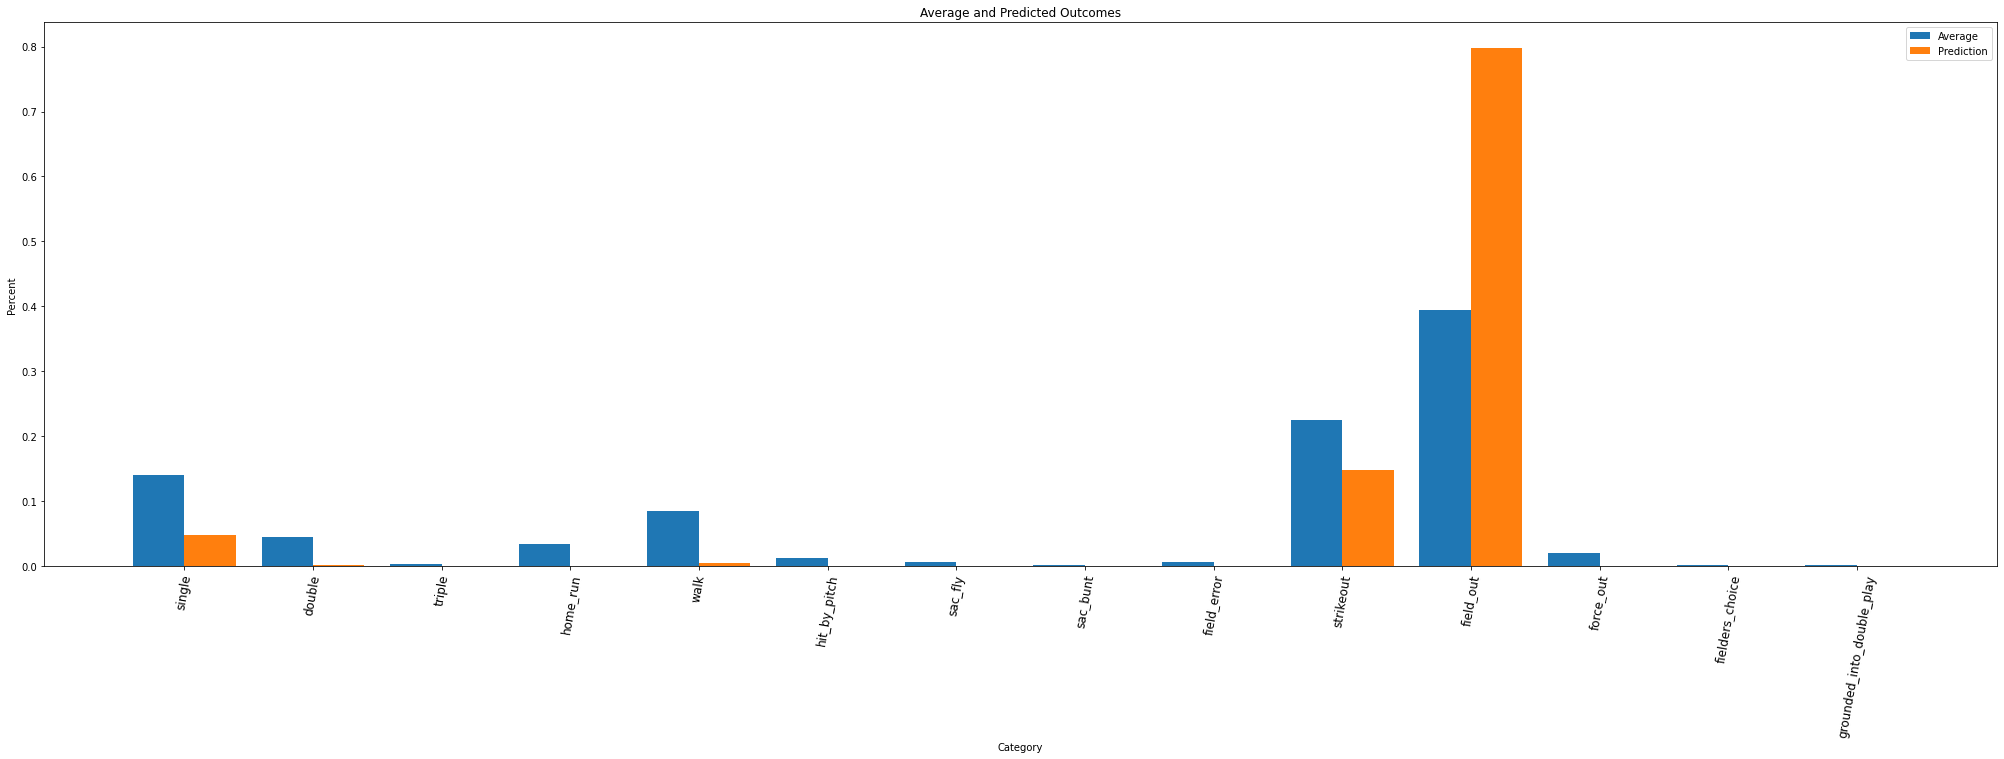

In [544]:

# Plot size:
figure(figsize = (35, 10))
 # All X Axis variables:
X = ["single", "double", "triple", "home_run", "walk", "hit_by_pitch", "sac_fly",  "sac_bunt", "field_error", "strikeout", "field_out", "force_out", "fielders_choice" , "grounded_into_double_play"]
 
# Establishing the averages and predicted percents for the first event:
avg = rf_averages.outcome.values
event_pred = rf_predicted_percs.iloc[0].values
 # Length of the range of the X axis:
X_axis = np.arange(len(X))
 # Plotting the bars associated with the average and predictions on the same plot:
plt.bar(X_axis - 0.2, avg, 0.4, label = 'Average')
plt.bar(X_axis + 0.2, event_pred, 0.4, label = 'Prediction')
 # Formatting:
plt.xticks(X_axis, X)
plt.xlabel("Category")
plt.ylabel("Percent")
plt.title("Average and Predicted Outcomes")
plt.xticks(rotation = 80, size = 12)
plt.legend()
plt.show()


## **"In The Dugout" Simulator** 

> New Notebook

- Add more data on individual player stats / change clusters
- Add data on players’ production in the past week
- Change format for outcome prediction / be able to compare to test set
- Make it update with different pitches/counts
-Instead, try to predict players’ average in 2021 given 2020, 2019, 2018 stats
predict era, k/9, whip, etc. off the spin rate and average velo of each pitch by pitcher; same for offensive stats and exit velo, launch angle, etc.
-Data Viz Idea: Every player — how they do against every pitch (and how often they see it) in 1 chart that is easy to understand
-Something like this: figure out which pitches pitchers should throw more often or which pitches hitters should sit on